# Bonds and Treasury Notes of the War of 1812

By David Cho and Alexander Dubasov

## Historical Context

In the decade leading up to the War of 1812, “republican simplicity” dictated national economic and financial policy. However, in the final years before the outbreak of war, the nation’s finances and banking system were in a precarious position. Before the war, land sales and customs duties generated most of the government’s revenue and the government did not impose an income tax on its citizens. 

## Outline 
Bonds and treasury notes issued during the war, according to Richard Bayley: 

1. Six Percent Loan of 1812
   - Exchanged Six Percent Stock
3. Treasury Notes
    - 1812 Issue
    - 1813 Issue
    - 1814 Issue 
6. Sixteen Million Loan of 1813
8. Seven and One-Half Million Loan of 1813
10. Six Percent Loans of 1814
    - Ten Million Loan
    - Six Million Loan
    - Undesignated Loan
12. Mississippi Stock
13. Temporary Loan of 1814 
14. Treasury Notes of December, 1814
15. Direct-Tax Loan
16. Temporary Loan of February 1815
17. Seven Per Cent. Stock of 1815
18. Treasury Notes of 1815
19. Small Treasury Notes of 1815
20. Treasury Note Stock of 1815
21. Temporary Loan of March, 1815
22. Six Per Cent. Loan of 1815

Each mini bond/note bio includes information on 

- Features for each bond/note
- Historical context and reasons for issuance
- How was the bond marketed?
- Who bought the bonds and notes?
- Sources 

Each mini bond/note bio includes the following graphs  

- Market Price: price of bond/note on the open market over time (dataset: `BondPrice.csv`)
- Quantity: quantity outstanding of bond/note over time (dataset: `BondQuant.csv`)  

<b>Notes</b>
1. 6% was a common interest rate set during this time. According to Perkins, since 1801, most other government bonds that had been issued typically had an interest rate between 5 and 6 percent.
2. Active oustanding, public holdings, and total outstanding were all the same. Therefore, the only quantity data were public holdings since public holdings are a sublevel of active outstanding, which itself is a sublevel of total outstanding. There could be many reasons for why there is only public holdings data, including simply the Treasury did not report matured or called oustanding. 

In [2]:
# Import Data
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import mplcursors
import numpy as np 
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator
from matplotlib.ticker import FuncFormatter
bond_price = pd.read_csv("data/BondPrice.csv")
bond_quant = pd.read_csv("data/BondQuant.csv") 

%matplotlib widget

In [50]:
# Add hovering features 
def show_hover_panel(df, scatplot, get_text_func=None):
    cursor = mplcursors.cursor(
        scatplot, 
        hover=2,  # Transient
        annotation_kwargs=dict(
            bbox=dict(
                boxstyle="square,pad=0.5",
                facecolor="white",
                edgecolor="#ddd",
                linewidth=0.5,
                path_effects=[pe.withSimplePatchShadow(offset=(1.5, -1.5))],
            ),
            linespacing=1.5,
            arrowprops=None,
        ),
        highlight=True,
        highlight_kwargs=dict(linewidth=2),
    )

    if get_text_func:
        cursor.connect(
            event="add",
            func=lambda sel: sel.annotation.set_text(get_text_func(df, sel.index)),
        )

    return cursor


def on_add(df, index):
    item = df.iloc[index]
    if df.columns[1] == "Price":
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Price: {item.Price:,.2f}",
        ]
    else:
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Quant: {item.Quant:,.2f}",
        ]

    return "\n".join(parts)

In [51]:
# reformat dataframe to create separate timestamp and price columns 
# drop NaN columns 
def melt_clean_price(df):
    # Drop columns with NaN 
    clean_df = df.dropna(axis=1) 
    df_melted = clean_df.melt(var_name='Timestamp', value_name='Price')
    df_melted = df_melted.iloc[2:].reset_index(drop=True)
    return df_melted

# remove ax from parameter and uncomment fig, ax 
# Graph for price function
def graph(df, title, graph_type):
    sns.set(style="darkgrid")
    # convert timestamp dtype into datetime dtype
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # Set up Seaborn plot
    
    fig, ax = plt.subplots(figsize=(10, 6))

    scatplot = sns.scatterplot(data=df, x='Timestamp', y=graph_type, marker='o')
    #scatplot.axvspan(xmin=pd.Timestamp("1819"), xmax=pd.Timestamp("1822"), fc="#E0837F")
    # Format x-axis ticks to show year 
    date_form = DateFormatter("%Y")

    #ax.xaxis.set_major_formatter(date_form)
    #ax.xaxis.set_major_locator(YearLocator(2))
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(YearLocator(2))
    
    # Get the minimum and maximum dates with data (assuming 'date' is a datetime type)
    min_date = df['Timestamp'].min()
    max_date = df['Timestamp'].max()
    # Set the x-axis limits to exclude extra years
    plt.xlim(min_date, max_date)

    # Enhance plot aesthetics (optional)
    plt.xlabel('Year')
    plt.title(title)
    plt.grid(True)

    if graph_type == "Quant":
        # reformat y-axis to be in millions, not tens of millions
        if df["Quant"].max() > 1e6:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e6)))
            plt.ylabel('Total Outstanding (millions)')
        else: # otherwise use hundred thousands label 
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e5)))
            plt.ylabel('Total Outstanding (hundred thousands)')

    show_hover_panel(df, scatplot, on_add) # add cursor hover features 

    plt.plot(df['Timestamp'], df[graph_type])
    
    return plt # return completed figure 

In [52]:
# clean quant dataframe 
# returns a series with chosen row 
def clean_quant(quant_df):
    subset_cols = quant_df.columns[2:] 
    # Drop rows where all columns are Nan 
    temp_clean_quant_df = quant_df.dropna(how="all", subset=subset_cols).dropna(axis=1)
    # print(clean_six_percent_prices)
    # print(temp_clean_six_percent_quant)
    
    # Define the threshold
    threshold = 0.001
    # Function to check if all values in a column are close to zero
    def is_close_to_zero(col, threshold):
        return np.all(np.abs(col) < threshold)
    
    cols_to_drop = [col for col in temp_clean_quant_df.iloc[:, 2:].columns if is_close_to_zero(temp_clean_quant_df[col], threshold)]
    
    # Drop the columns
    clean_quant_df = temp_clean_quant_df.drop(columns=cols_to_drop)
    return clean_quant_df
    # print(clean_quant_df) 

def reformat_quant(clean_quant_df, row):
    # reformat dataframe to include timestamp and quant columns 
    series_data = clean_quant_df[clean_quant_df["Series"] == row].melt(var_name='Timestamp', value_name='Quant')
    series_data = series_data.iloc[2:].reset_index(drop=True)
    series_data['Timestamp'] = pd.to_datetime(series_data['Timestamp']) #convert timestamp column to a datetime object 
    return series_data # return the selected row 

# Add a historical marker
# An important event 
def add_marker(axis, event_str, date, y_coord, font_size):
    axis.annotate(event_str,
            xy=(pd.Timestamp(date), y_coord), xycoords='data',
            xytext=(30, 10), textcoords='offset points', size=font_size, 
            arrowprops=dict(facecolor='black', shrink=0.05))

# color background to define a period
def add_period(plot, begin, end):
    # ax.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')
    plot.axvspan(xmin=pd.Timestamp(begin), xmax=pd.Timestamp(end), fc="#E0837F")

## Six Percent Loan of 1812

### Overview and Features
<b>Six Percent Loan of 1812:</b> Congress allowed the President to borrow no more than **\\$ 11 million** through an act passed on March 14, 1812, three months before the war officially began. The interest rate was set at **6%, in quarterly payments** [1]. Bonds could be redeemed starting January 1, 1825. **Bonds could not be sold below par**. The treasury obtained <b>\$ 8,134,700</b> through issuing these stock certificates [1].

<b>Temporary Loan of 1812:</b> Authorized by the same act on March 14, 1812 that authorized the six percent loan of 1812. Bonds were redeemable based on contracts. Sold at par and at **6% interest in quarterly payments**. The final redemption occured on June 28, 1817. Around **\$2,150,000** was obtained under special contracts with various banks according to Bayley [1]. 

<b>Exchanged Six Percent Stock: </b>Congress authorized the exchanged six percent stock through an act on June 24, 1812. The act allowed individuals to trade in their old six percent stock in exchange for new six percent stock. These new stocks had the same features as the original stock. Gallatin had noted that by June, the \\$ 11 million loan only managed to bring in \\$ 6.46 million. Gallatin thought the new stock would increase the price of the bonds since according to Gallatin the old stock was selling 2-3% below par. The Treasury collected around **\\$ 2,984,746** worth of subscriptions of the exchanged six percent stock. The act did not have any new features compared to the old six percent stock. The act explicitly protected those who purchased the old six percent stock and did not wish to subcribe to the exchanged stock. The only individuals and banks who could purchase the new six percent stocks were those who already had the old six percent stock [1].

### Marketing and Buyers 
Not many banks and individuals were not interested in buying government debt and the modest interest rate (6%) did not excite many potential buyers. Another reason Potential buyers did not buy the six percent stock was because they were nervous that the United States could suffer defeat against Britain, who had the largest army and navy at the time. New Englanders remained unsympathetic to the war and Congress did not find a way to fulfill interest payments, which did not raise confidence. Meanwhile, securities markets were primarily regional, located in major cities such as New York. American firms lacked the ability to underwrite large securities issues, and American agents in Europe could not underwrite American securities issues. Due to the lack of capability, the Treasury announced the six percent bonds and simply waited for investors to come, but only \\$ 6.2 million was initially bought [2].

1. **\$4.2 million** bought by **banks** for their long-term portfolios.
2. **\$2.0 million** bought by **individuals** [2].  

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] *American Public Finance and Financial Services 1700-1815* by Edwin J. Perkins (327-330) 

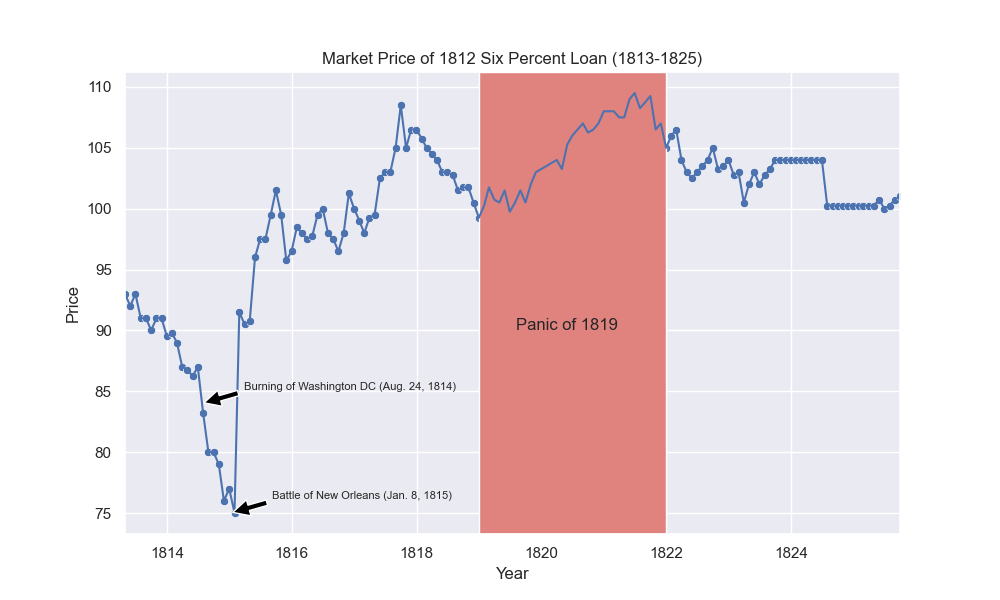

In [54]:
%matplotlib widget
# Six percent loan of 1812 
# prices 
six_percent_prices = bond_price[bond_price["L1 ID"] == 20048] 
six_percent_prices_melted = melt_clean_price(six_percent_prices) # clean and melt (reformat) dataframe 
six_percent_plot = graph(six_percent_prices_melted, 'Market Price of 1812 Six Percent Loan (1813-1825)', "Price")

# historical annotations 
add_marker(six_percent_plot, 'Burning of Washington DC (Aug. 24, 1814)', "1814-7-24", 84, 8)
add_marker(six_percent_plot, 'Battle of New Orleans (Jan. 8, 1815)', "1815-1-08", 75, 8) 
# Panic of 1819 
add_period(six_percent_plot, "1819", "1822")
six_percent_plot.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')

six_percent_plot.show()

Prices dipped substantially during the latter half of 1814. From the end of June, 1814 to the end of January, 1815, prices decreased by 13.79%. The decrease in price coincides with the British Chesapeake campaign which saw the burning of Washington DC. The uptick in prices after January, 1815 can be explained by the signing of the Treaty of Ghent, ending the war. The market price reached a maximum of \\$ 109.50 by the end of June, 1822. The period from 1819 to the latter half of 1822 saw an increase in the price, coinciding with the Panic of 1819 and the ensuing financial crisis. 

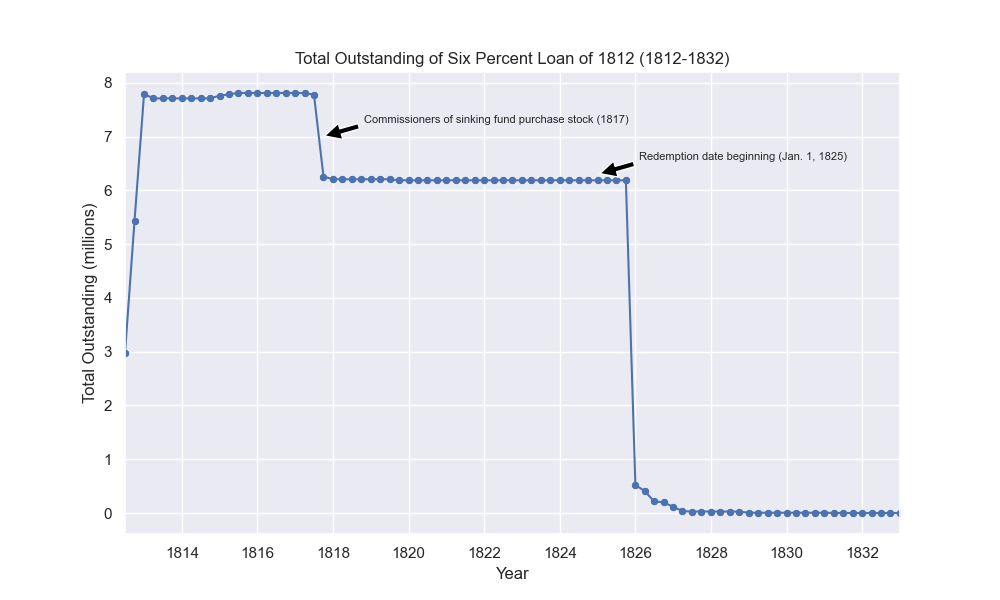

In [63]:
# quantities 
six_percent_quant = bond_quant[bond_quant["L1 ID"] == 20048]
clean_six_percent_quant = clean_quant(six_percent_quant)
#print(clean_six_percent_quant) 
total_outstanding = reformat_quant(clean_six_percent_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Six Percent Loan of 1812 (1812-1832)", "Quant") 

# add historical dates 
add_marker(total_outstanding_plot, 'Commissioners of sinking fund purchase stock (1817)', "1817-9-20", 7e6, 8)
add_marker(total_outstanding_plot, 'Redemption date beginning (Jan. 1, 1825)', "1825-1-01", 6.3e6, 8)

total_outstanding_plot.show()
six_percent_1812_quant = total_outstanding

Total outstanding of approximately 3 million at the end of June 1813. By the end of 1813, total oustanding increases to 7.7 million. Slight uptick at the end of 1814, at the war's conclusion. Quantity drops from 7.78 million to 6.26 million between July and September of 1817; 19.57% decrease (-\\$ 1,522,048); according to Bayley, the commissioners of the sinking fund purchased \\$ 1,603,997 at that time. There was a 91.57% decrease in total outstanding from October to December 1825; most likely cause were that bonds became redeemable starting January, 1825. The maximum quantity outstanding was \\$ 7,810,500, way below the \\$ 11 million authorized by Congress. 

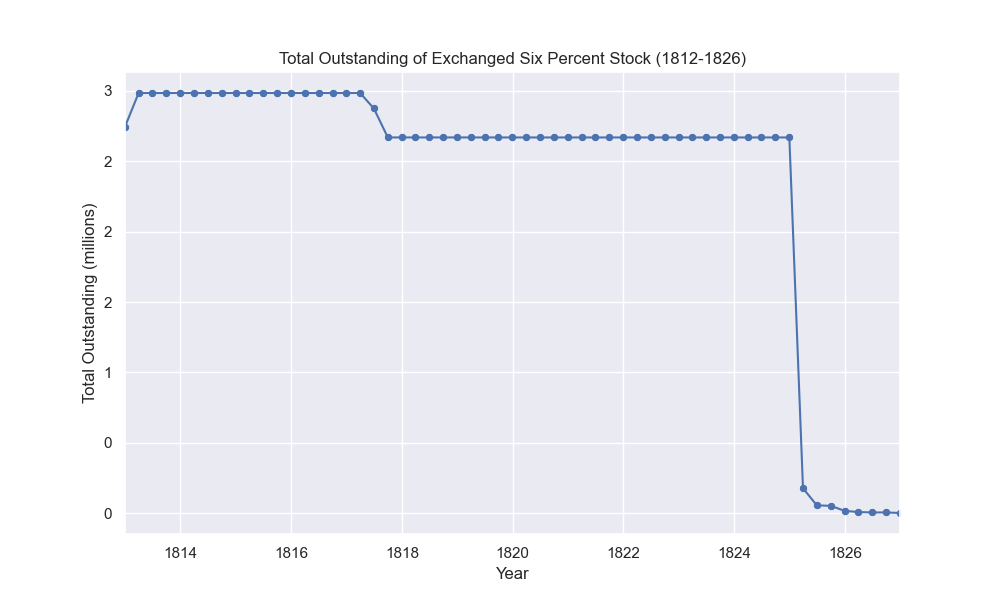

In [8]:
# quantities 
exchanged_six_quant = bond_quant[bond_quant["L1 ID"] == 20051]
clean_exchanged_six_quant = clean_quant(exchanged_six_quant)
total_outstanding = reformat_quant(clean_exchanged_six_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Exchanged Six Percent Stock (1812-1826)", "Quant") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_exchanged_six_quant, "Public Holdings")
exchanged_six_quant = total_outstanding 

There is a sharp decrease in total outstanding from December, 1824 through March, 1825 from \\$ 2,668,974.99 to \$ 177,650.18, a 93.34% decrease. The decrease was most likely caused by the fact that the stock became redeemable after December 31, 1824.  

# Treasury Notes

Treasury notes were short term bonds that the government issued during the War of 1812 to make up for the poor selling of long-term bonds. These notes were typically redeemable after 1 year and could be used to pay duties, taxes, and purchase land. In total, there were five separate issues of notes. While early issues had large denominations (e.g. \\$100 and \\$1000), future issues included smaller denominations (e.g. \\$3 and \\$20). Overall, these notes were a success by acting as a form of paper currency.

Source: *Monetary Aspects of the Treasury Notes of 1812* by Donald H. Kagin

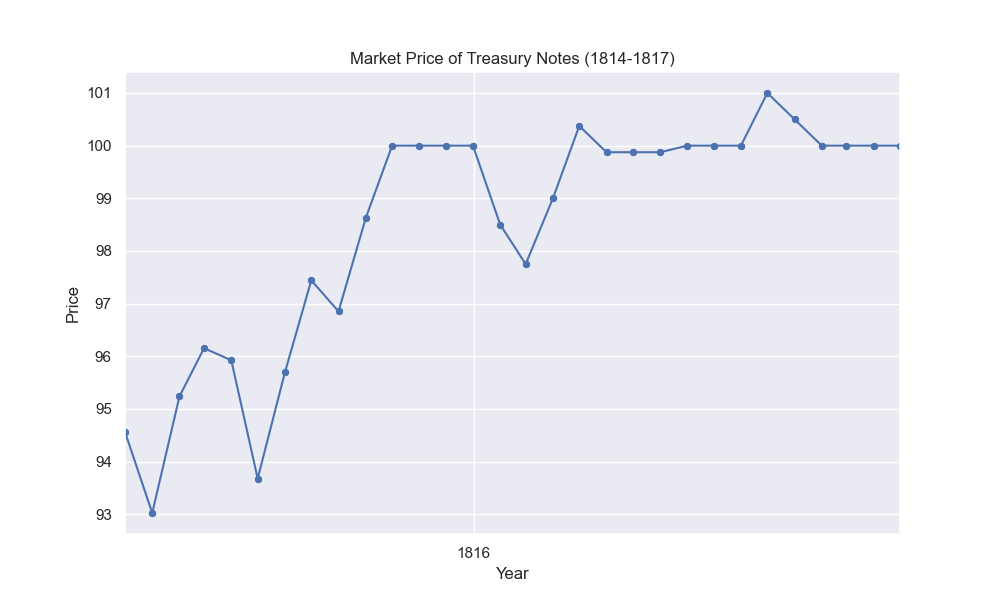

In [45]:
# Market Price of Treasury Notes 
treasure_notes_prices = bond_price[bond_price["L1 ID"] == 20050] 
treasure_notes_melted = melt_clean_price(treasure_notes_prices) # clean and melt (reformat) dataframe 
treasure_notes = graph(treasure_notes_melted, 'Market Price of Treasury Notes (1814-1817)', "Price")

treasure_notes.show()

Market price data starts November, 1814. This aligns with the total outstanding records which show the first redemptions occuring in the second quarter of that year. The market price data also has a shorter date range. This is most likely due to the fact most of the Treasury notes were redeemed quickly (little more than a year) after they were issued. Price hovered around \\$ 100, impying the most common denomination on the market was \\$ 100. 

## Issue of 1812

### Overview and Features
The first issue of treasury notes were authorized by Congress on June 30, 1812. Congress decided to authorize the notes as a result of the Six Percent Loan in 1812 failing to attract enough buyers and an estimated \\$ 11 million deficit. Many Congressmen opposed the treasury notes and wanted to use other revenue sources such as taxation. They argued banks and people scared of paper money would not purchase treasury notes because they weren't worth as much in gold or silver and that they would appreciate like the Continental Currency during the American Revolution. Meanwhile, supporters argued silver was in short supply and gold was undervalued. Therefore, coins could not be made. Treasury notes were seen as a good replacement for the First Bank of the US's notes. Depreciation would be avoided because notes could be used to pay off taxes and banks would keep them in their reserves [3]. 

The act authorizing the notes states no more than **\\$ 5 million** could be issued. The interest rate was set at **5.4%** and the bond could be redeemed after 1 year. Notes were **sold at par**. The only two denomations for the first issue were: \\$ 100 and \\$ 1000 [1]. 

### Marketing and Buyers
Treasury notes could be be used to pay off taxes, duties, and debts [1]. These Treasury notes could also be exchanged for long-term bonds paying 7 percent interest [2]. <b>$3.5 million</b> ended up being sold to banks, mostly located in Mid-Atlantic states. By December 1, the remaining bills were sold off, many going to New England. According to Treasury Secretary Alexander Dallas, Treasury notes were bought primarily by "necessitous creditors, or contractors in distress, or commissaries, quartermasters, and navy agents acting officially." Kagin cites the Niles Weekly Register, who observed how banks primarily used the notes as reserves, meaning they were not circulating. In his report to Congress, Secretary Dallas states most notes went towards paying taxes [3].

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] [The American Numismatic Association](https://www.money.org/tales-from-the-vault-war-of-1812-treasury-notes/)
- [3] *Monetary Aspects of the Treasury Notes of the War of 1812* by Donald H. Kagin 

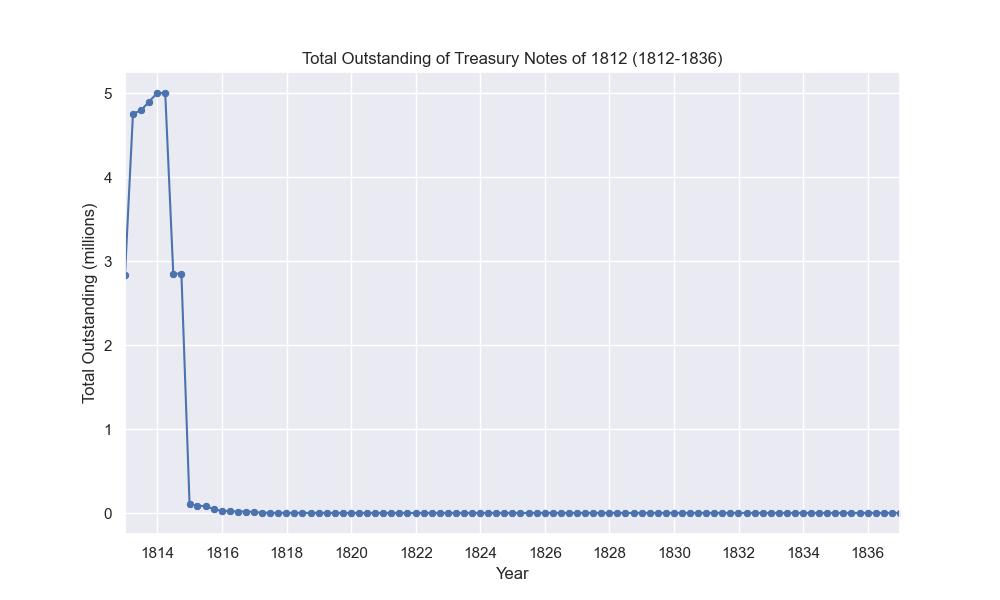

In [10]:
# quantities 
treasure_notes_1812_quant = bond_quant[bond_quant["L1 ID"] == 20050]
clean_treasure_notes_1812_quant = clean_quant(treasure_notes_1812_quant)
# print(clean_treasure_notes_1812_quant) 
total_outstanding = reformat_quant(clean_treasure_notes_1812_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Treasury Notes of 1812 (1812-1836)", "Quant") 
total_outstanding_plot.show()

treasury_notes_1812_quant = total_outstanding 

The 1812 issue of Treasury notes reached its authorized limit of \\$ 5 million by the end of 1813. The data aligns with Kagin's statement that "the first issue of Treasury Notes was quite successful" and that "the rest of the bills were disposed of by December 1 the following year [1813]." After March 1814, the total outstanding falls sharply. By the end of 1814, the total outstanding had decreased by 97.84%. This sharp decrease aligns with the fact that Treasury notes were meant to be short-term bonds and were redeemable after a year they were issued. 

## Issue of 1813 

### Overview and Features 
Gallatin wanted to replace the Treasury notes authorized in 1812 because the war effort required an additional borrowing of \\$ 19 million. Republicans refused to raise taxes. The \\$ 5 million in notes would be a part of the \\$ 16 million loan passed on February 8. Congress intended these notes to supplement shortfalls in long-term loans. However, Congress did nothing to support the notes in circulation and . Gallatin's plan did not succeed [2]. Madison would ask Congress for an additional \\$ 7.5 million [4]. 

Congress authorized the treasury notes on February 25, 1813. They allowed the Treasury to issue no more than <b>\$ 5 million</b>. The bonds <b>sold at par</b>. Buyers could redeem them after <b>one year</b>. Congress set a fixed interest rate of <b>5.4%</b>. Agents earned a commission of 1/4th of a cent [1]. Congress only issued notes in \\$100 and \\$1000 denominations [3]. Congress allowed individuals to give their notes to another person [5]. While most treasury notes were redeemed after a year, some were converted to long-term bonds with seven percent interest [6]. 

### Marketing and Buyers
The Treasury considered the notes as legal tender and notes could accrue short-term interest [2]. Despite the large denominations, Congress allowed individuals to give notes to each other and use notes to pay taxes, duties, and buy land. When using treasury notes to pay, the holder earned the principal amount and accrued interest [5]. Banks used Treasury notes for their reserves. Since these early Treasury notes had high denominations and could be used as payment, wealthy Americans and merchants purchased and used them more [2]. 

Treasury Secretary Dallas stated in a report in 1815, the Treasury notes issued before 1815 could not be used effectively as a medium of exchange because Congress set the denominations too high (\\$ 100 and \\$ 1000), which made the early issues (before 1815) unappealing to individuals. 

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] *Monetary Aspects of the Treasury Notes of 1812* by Donald H. Kagin 
- [3] [*Treasury notes fill gap to support War of 1812* by Paul Gilkes](https://www.coinworld.com/news/paper-money/treasury-notes-fill-gap-to-support-war-of-1812.html)
- [4] <I>Financing the War of 1812</i> by Brandy Heritage Center
- [5] <I>An Act authorizing the issuing of Treasury notes for the service of the year one thousand eight hundred and thirteen</I> by the Twelfth Congress
- [6] American Public Finance and Financial Services 1700-1815 by Edwin J. Perkins (337) 

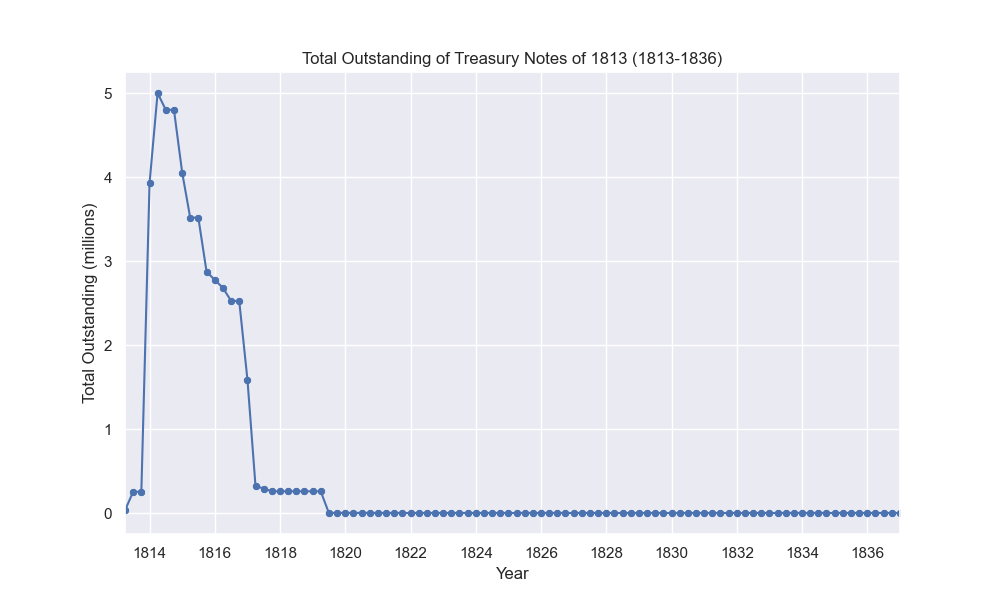

In [11]:
# quantities 
treasury_notes_1813_quant = bond_quant[bond_quant["L1 ID"] == 20053]
clean_treasury_notes_1813_quant = clean_quant(treasury_notes_1813_quant)
total_outstanding = reformat_quant(clean_treasury_notes_1813_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Treasury Notes of 1813 (1813-1836)", "Quant") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_treasury_notes_1813_quant, "Public Holdings")
treasury_notes_1813_quant = total_outstanding 
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()

The amount of Treasury notes issued reached the maximum \$ 5 million authorized by Congress by the end of March, 1814. In the same month, the first notes could be redeemed, after which the quantity decreased drastically over the next three years. 

## Issue of March, 1814

### Overview and Features
War expenditures had ballooned to \\$ 45.4 million with Treasury revenue only at \\$ 16 million. Congress had already authorized a \\$ 25 million loan in March 4, 1814 with approximately **\\$ 10 million worth** of Treasury notes meant to be a part of that loan. Notes could be redeemed **one year** from date. The interest rate was set at **5.4%** which would be paid on redemption. The notes **sold at par**. Similar to previous issues, these Treasury notes could be used to pay taxes, duties, or purchase public lands [1]. The notes came in three denominations: \\$ 1000, \\$ 100, and the newly added \\$ 20 [2]. 

### Marketing and Buyers 
Agents were given a commission of 1/4th of one percent sold. The Treasury Secretary noted that the notes were popular for the following reasons: buyers were confident they would be reimbursed at the end of the year and their usefulness as a currency for what he called "remittances and other economical operations" [1]. The \\$ 20 denominations were intended to be used as hand currency so more money could end up in circulation, but the Treasury Secretary specifically avoided making the notes legal tender. Buyers also had the option of converting the notes into long-term seven percent interest bonds which helped maintain the value of the notes, unlike the Continental Currency, making them more stable and appealing [3]. In the end, large numbers of these Treasury notes would not end up in circulation as intended [2]. 

#### Sources 
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] <i>Monetary Aspects of the Treasury Notes of the War of 1812</i> by Donald H. Kagin (78-79) 
- [3] *American Public Finance and Financial Services 1700-1815* by Edwin J. Perkins (330) 

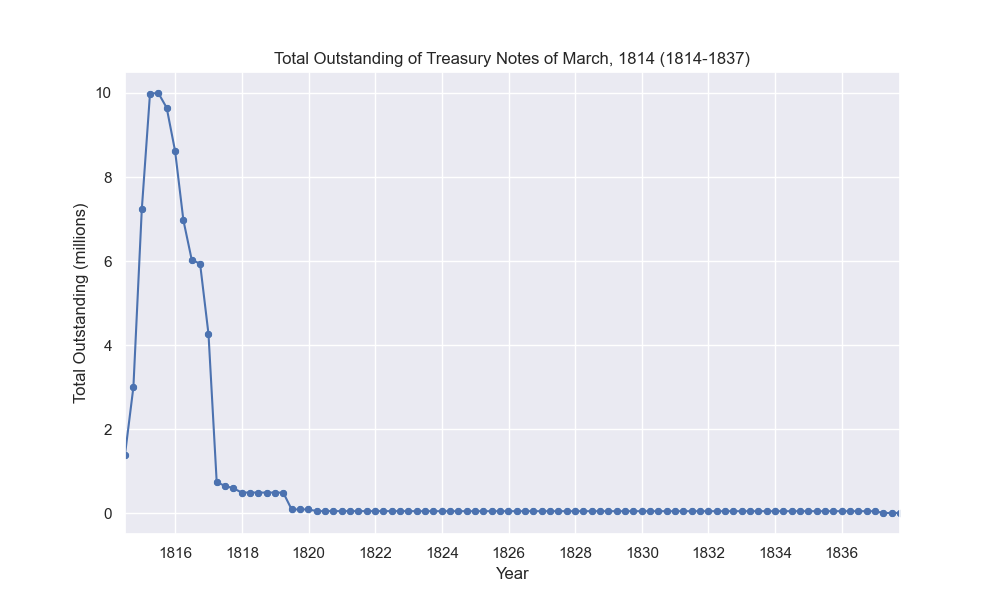

In [17]:
# quantities 
notes_1814_quant = bond_quant[bond_quant["L1 ID"] == 20055]
clean_notes_1814_quant = clean_quant(notes_1814_quant)
total_outstanding = reformat_quant(clean_notes_1814_quant, "Total Outstanding")
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Treasury Notes of March, 1814 (1814-1837)", "Quant") 
total_outstanding_plot.show()
treasury_notes_1814_quant = total_outstanding 

Most Treasury notes were redeemed in the latter half of 1815 and through 1816 since These treasury notes were meant to be short-term bonds. The significant quantity of notes after 1820, relative to the previous two issues of notes, can be explained by the fact there were three denominations instead of two. By the 1830s, quantity typically decreases by \\$ 20, implying that \\$ 20 notes are still being redeemed.

## Sixteen Million Loan of 1813 

### Overview and Features
Congress authorized the \\$ 16 million loan on February 8, 1813. The loan was necessary since Treasury notes and import duties failed to cover war expenses. The interest rate was set at **6%, payable quarterly**. Bonds would be redeemable after January 1, 1826. They **sold at 88 percent** face value. **\\$ 18,109,377.43** was issued [1]. 

### Marketing and Buyers

Banking institutions did not buy the bonds. Potential buyers were scared of America losing the war. By March, the loan had a shortfall of \$ 10 million. Therefore, Gallatin began relying on wealthy individuals to make up for the deficit. 

**Stephen Girard**: He was a French native, banker, and financier. He operated a private bank in Philadelphia out of the First BUS building. He remained friends with Secretary Gallatin. He agreed to help make up for the \\$ 10 million shortfall. His decision increased public confidence [2]. 

**David Parish**: He was an agent of a Philadelphia banking house and son of Parish and Company, a firm from Hamburg, Germany. He had experience in underwriting securities and forming syndicates [4]. He made most of his wealth from land speculation [3]. 

**John Jacob Astor**: He was an immigrant from Germany who lived in New York City. He made his money from the fur trade, selling opium to China, and real estate. He was the first member of the powerful Astor family to live in America [4]. He was also one of the richest men in America [5]. 

Girard, Parish, and Astor agreed to form a syndicate. They purchased \\$ 10.1 million worth of 6 percent bonds at \\$ 88 discounted. Girard and Parish's personal shares were \\$ 3.1 million and Astor's was \\$ 1.5 million. The three syndicate members hired at least seven firms from Phildadelphia, New York, and Baltimore to purchase the remaining \\$ 2.4 million. The syndicate did not bear any financial risk and they would market their combined total of \\$ 7.7 million, earning \\$ 11,510 in commissions [4].  

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] *Girard to the Rescue: Stephen Girard and the War Loan of February 8, 1813* by Mark T. Hensen
- [3] [David Parish](https://en.wikipedia.org/wiki/David_Parish)
- [4] American Public Finance and Financial Services 1700-1815 by Edwin J. Perkins (331) 
- [5] [John Jacob Astor](https://en.wikipedia.org/wiki/John_Jacob_Astor)

/var/folders/ct/jjmfnk013tn1r7zs75r9b1gw0000gn/T/ipykernel_81961/2818110535.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


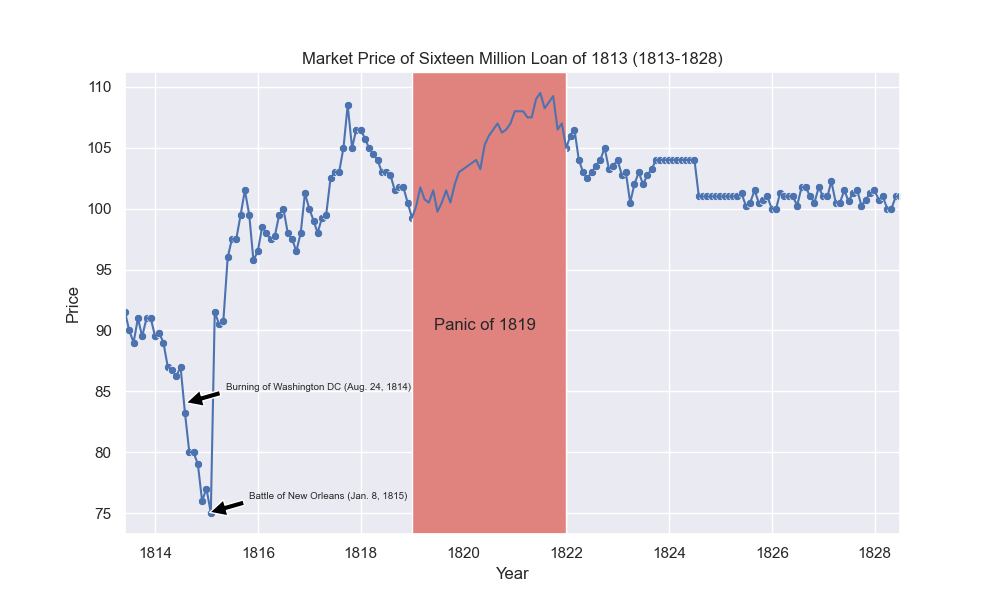

In [35]:
# Sixteen million loan of 1813 
sixteen_mil_prices = bond_price[bond_price["L1 ID"] == 20052] 
sixteen_mil_melted = melt_clean_price(sixteen_mil_prices) # clean and melt (reformat) dataframe 
sixteen_mil = graph(sixteen_mil_melted, 'Market Price of Sixteen Million Loan of 1813 (1813-1828)', "Price") 

# historical annotations 
add_marker(sixteen_mil, 'Burning of Washington DC (Aug. 24, 1814)', "1814-7-24", 84, 7)
add_marker(sixteen_mil, 'Battle of New Orleans (Jan. 8, 1815)', "1815-1-08", 75, 7) 
# Panic of 1819 
add_period(sixteen_mil, "1819", "1822")
sixteen_mil.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')

sixteen_mil.show()

The market price for 1813 six percent bonds is almost identical to the 1812 six percent stock (old and exchanged); these bonds traded at the same time. There are differences. The data for the 1813 bonds begins one month later (in June compared to May for the 1812 bonds). The data continues the 1812 six percent since the 1813 bonds were redeemable a year (1826) later than the 1812 six percent bonds (1825). 

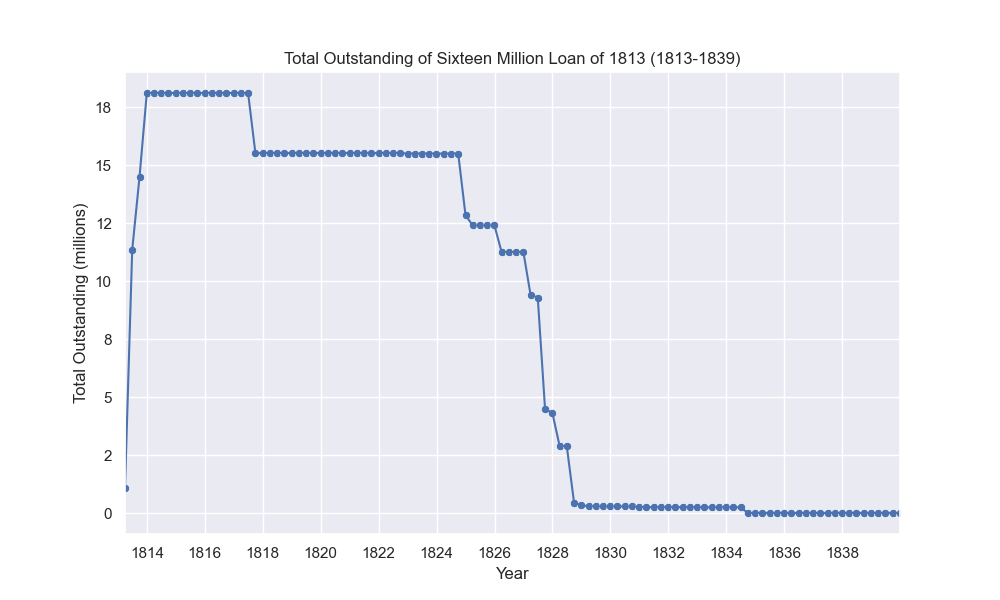

In [19]:
# quantities 
sixteen_mil_quant = bond_quant[bond_quant["L1 ID"] == 20052]
clean_sixteen_mil_quant = clean_quant(sixteen_mil_quant)
total_outstanding = reformat_quant(clean_sixteen_mil_quant, "Total Outstanding")
# print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Sixteen Million Loan of 1813 (1813-1839)", "Quant") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_sixteen_mil_quant, "Public Holdings")
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()
#print(public_holdings.equals(total_outstanding))
sixteen_mil_quant = total_outstanding 

A total of \\$ 18,109,377 million was issued. The additional \\$ 2,109,377.43 came from the fact the bond was sold at a discount. The decrease in total outstanding from June to September 1817 overlaps with a decrease in total outstanding during that same time period for the 1812 six percent bonds (-\\$ 2,580,943.7). According to Bayley, in 1817, the commissioners of the sinking fund purchased \\$ 2,580,943.7 at par. For the other decreases in the years following, acts by Congress in 1822, 1824, and 1825 saw the amount redeemed exchanged for new interest-bearing stocks. 

## Seven and One-Half Million Loan of 1813 

### Overview and Features
Congress authorized a loan of **\\$ 7.5 million** on August 2, 1813. The bonds sold at **88.25% face value**, a discount. They could not be sold less than \$ 88. Buyers could redeem them after Jan. 1, 1826. Congress set a fixed interest rate of **6%** and interest paid **quarterly** [1]. 

Secretary of the Navy William Jones became acting Treasury Secretary in May, 1814. Jones requested a long-term loan because he feared that Treasury notes could depreciate [1]. Congress set aside \\$ 8 million for interest payments and reimbursement [2]. Jones sold \$ 8.5 million worth of the bonds at a discount. Gallatin stated the bonds sold quicker than the \\$ 16 million loan in 1812 [3]. According to Jones, the entire loan had been subscribed by the first months of 1814 [3]. The final redemption occurred on August 2, 1845 [1]. 

### Marketing and Buyers
Agents earned a commission of 1/4th of a cent [1]. The commission provided an incentive for individuals and banks to market the loan. The bond sold at a ~12% discount to try and attract more buyers. New England was not considered a willing market for these bonds due to opposition to the war. Southern states, south of Baltimore, did not have properly organized capital markets to facilitate these bonds. The government chose not to ask for help from outside financiers such as Girard, Astor, or Parish [4].  

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] <I>An Act authorizing a loan for a sum not exceeding seven millions five hundred thousand dollars.</I> by Thirteenth Congress
- [3] <I>The Financial History of the War of 1812</I> by Lisa R. Morales
- [4] <I>American Public Finance and Financial Services 1700-1815</i> by Edwin J. Perkins (332) 

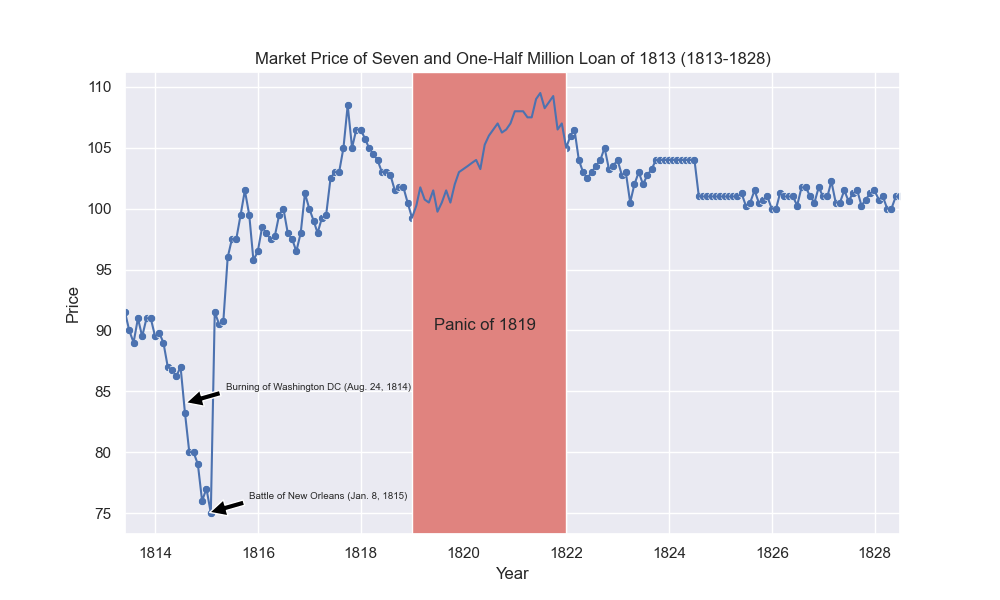

In [36]:
# seven and one-half million loan of 1813 
seven_one_half_prices = bond_price[bond_price["L1 ID"] == 20054] 
seven_one_half_melted = melt_clean_price(seven_one_half_prices) # clean and melt (reformat) dataframe 
seven_one_half = graph(seven_one_half_melted, 'Market Price of Seven and One-Half Million Loan of 1813 (1813-1828)', "Price") 

# historical annotations 
add_marker(seven_one_half, 'Burning of Washington DC (Aug. 24, 1814)', "1814-7-24", 84, 7)
add_marker(seven_one_half, 'Battle of New Orleans (Jan. 8, 1815)', "1815-1-08", 75, 7) 
# Panic of 1819 
add_period(seven_one_half, "1819", "1822")
seven_one_half.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')

seven_one_half.show()

The market price of the bonds were identical to the previous Sixteen Million Loan of 1813. These bonds shared the same features and redemption date. Therefore, they must had been grouped and traded together. 

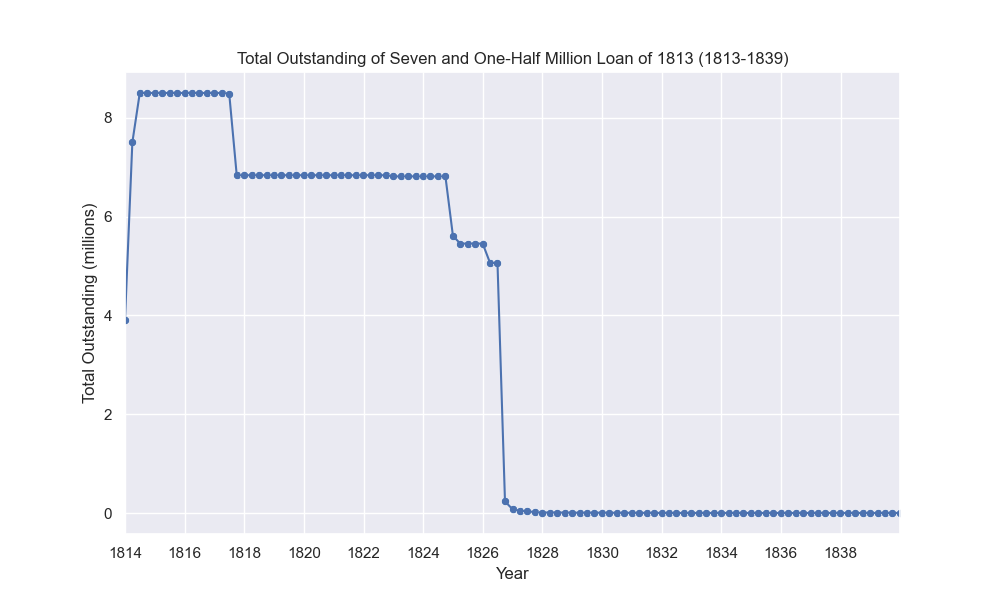

In [20]:
# quantities 
seven_one_half_quant = bond_quant[bond_quant["L1 ID"] == 20054]
clean_seven_one_half_quant = clean_quant(seven_one_half_quant)
#print(clean_seven_one_half_quant) 
total_outstanding = reformat_quant(clean_seven_one_half_quant, "Total Outstanding")
#print(total_outstanding)
total_outstanding_plot = graph(total_outstanding, "Total Outstanding of Seven and One-Half Million Loan of 1813 (1813-1839)", "Quant") 
total_outstanding_plot.show()

public_holdings = reformat_quant(clean_seven_one_half_quant, "Public Holdings")
seven_one_half_quant = total_outstanding 
#public_holdings_plot = graph_quant(public_holdings, "Public Holdings of Exchanged Six Percent Stock (1812-1817)") 
#public_holdings_plot.show()

The total outstanding follows a similar trend to the two previous long-term six percent bonds. There is a decrease in total oustanding from June to September, 1817. This aligns with Bayley's note that the comissioners of the sinking fund purchased \\$ 1,662,349.56 at par during the same time period. The comissioners of the sinking fund also purchased large amounts of the two previous long-term bonds during the same time. The decreases in total oustanding in 1824, 1825, and 1826 were due to acts of Congress that exchanged the amount redeemed for new 4.5% stock. 

## Six Percent Loans of 1814

### Overview and Features
In 1814, the Treasury reported an estimated \\$ 29.4 million deficit. In addition, previous funds raised from bonds in 1813 had all been used up in fighting in Canada. Therefore, Congress authorized a long-term loan of \$ 25 million on March 24, 1814. Different amounts of the loan would be raised at different times in the hopes of getting more subscribers [1].  

<b>Ten Million Stock:</b>
Redeemable after December 31, 1826. It sold at a discount of **80 percent face value**. Interest rate was set at **6 percent** in **quarterly** payments on January, April, July, and October. Agents received a commission of 1/4th of one cent sold. Congress appropriated \$ 8 million to reimburse and pay interest on the loan. 
Amount of Stock Issued (Ten Million Loan): <b>\$ 9,919,476.25</b> [1].

<b>Six Million Stock:</b>
Same features as the Ten Million Stock. 
Amount of Stock Issued (Six Million Loan): <b>\$ 5,384,134.87</b> [1].

<b>Undesignated Stock</b>
For the most part, the same features as the Six Million and Ten Million Stock. However, stocks sold anywhere between **80-95% face value**. 
Amount of Stock Issued (Undesignated Loan): <b>\$ 746,403.31</b>
[1]. 

### Marketing and Buyers 
<b>Ten Million Loan:</b> Treasury Secretary George W. Campbell realized he would struggle to raise \\$ 25 million at once. He decided to raise \\$ 10 million first. He received offers totaling \\$ 11.9 million without relying on loan contractors. He sold \\$ 9.2 million at \\$ 88 per subscription. He ignored the remaining \\$ 2.7 million since they offered less per subscription [1][2].Jacob Barker, a successful New York merchant, purchased \\$ 5 million worth of bonds (half of the total 10 million). Barker used a leveraged transaction to buy them; Barker sought loans from banks in the northeast to purchase the bonds and used the bonds as collateral [2]. 

<b>Six Million Loan:</b> A new proposal of \$ 6 million was offered beginning July 25, 1814. Bonds were sold at a discount of 20 percent. Due to the discount, the Treasury offered a rebate to the original buyers of the Ten Million Loan at a rate of \\$ 10 per hundred of stock held. Thus, the Treasury protected initial buyers from the price decrease. Agents earned commissions of 1/4th of one percent on any subscriptions over \\$ 25000 [1]. **Six Philadelphia banks** took \\$ 250,000 for Philadelphia's military defenses. **Seven Baltimore banks** took \\$ 675,000 for their city's defenses [1]. British forces would capture Washington DC that August and launch an assault on Baltimore in September [5]. The **corporation of New York City** subscribed to \\$ 1,100,000.87 worth of stocks for supplies and reinforcements of the city. Bayley also mentions the Baltimore committee of vigilance and safety and the Planters' Bank of Savannah as buyers [1]. Overall, the six million stock failed to sell due to the British invasion during the Chesapeake campaign. Therefore, \\$ 3 million were sent to Europe for sale, most likely to **David Parish** in Hamburg, Germany [2]. 

<b>Undesignated Loan:</b> Subscriptions were obtained through contracts with corporations and banks. The contracts would have allowed specific terms to be negotiated, such as selling price. Several **corporations in Baltimore** subscribed to \\$ 150,000 of bonds to build a steam frigate to defend the city's port. The **Bank of Pennsylvania** subscribed to \\$ 43,222. The **Bank of Columbia** subscribed to \\$ 25000 and \\$ 100,000 from the Mechanics' Bank of Alexandria. 


Bank of Columbia: located in the Washington DC (District of Columbia) \
Bank of Pennsylvania: established in 1793 and located in Philadelphia [4]. <br> 
Mechanics' Bank of Alexandria: chartered by Congress [2]; first incorporated in Alexandria, Virginia by an act of Congress in 1812 [3].  

#### Sources
- [1] *The National Loans of the United States From July 4, 1776 to June 30, 1880* by Richard Bayley
- [2] <i>American Public Finance and Financial Services 1700-1815</i> by Edwin J. Perkins (334)
- [3] <i>An Act to incorporate a Bank in the town of Alexandria, by the name and style of the Mechanics' Bank of Alexandria</i> by Twelfth Congress
- [4] *A History of Pennsylvania. Penn State Press.* by Philip Shriver Klein and Ari Hoogenboom (273)
- [5] [Battle of Baltimore by National Park Service](https://www.nps.gov/fomc/learn/historyculture/battle-of-baltimore.htm)

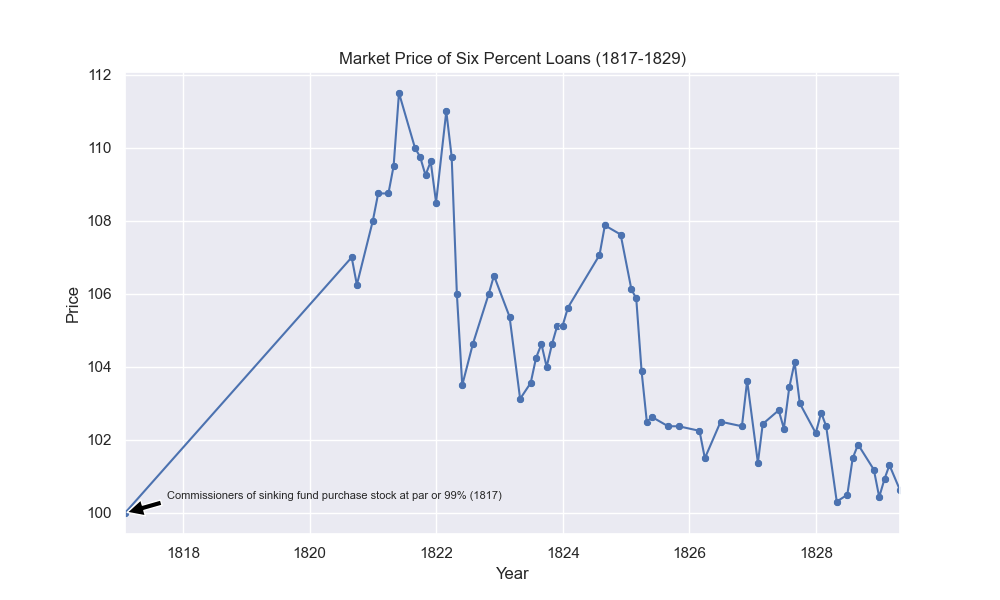

In [38]:
# 10 mil loan of 1814 
six_percent_prices = bond_price[bond_price["L1 ID"] == 20056] 
six_percent_melted = melt_clean_price(six_percent_prices) # clean and melt (reformat) dataframe 
six_percent = graph(six_percent_melted, "Market Price of Six Percent Loans (1817-1829)", "Price") 
add_marker(six_percent, 'Commissioners of sinking fund purchase stock at par or 99% (1817)', "1817-1-31", 100, 8)
six_percent.show()

Since all three stocks were technically issued as part of one larger \$ 25 million loan, the market price of all three bonds are the same. 

In [40]:
# create an interactive scatter plot of quantity data 
def generate_quant_plot(quant_df, title, axis):
    axis.plot(quant_df["Timestamp"], quant_df["Quant"])
    # c_quant_df = quant_df.drop_duplicates(subset=["Quant"], keep="last") # drop duplicate points to keep graph minimalist 
    quant_scatplot = axis.scatter(data=quant_df, x='Timestamp', y='Quant', marker='o')
    axis.title.set_text(title)

    # reformat y-axis to be in millions, not tens of millions
    if quant_df["Quant"].max() > 1e6:
        axis.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e6)))
        plt.ylabel('Total Outstanding (millions)')
    else: # otherwise use hundred thousands label 
        axis.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e5)))
        plt.ylabel('Total Outstanding (hundred thousands)')
        
    show_hover_panel(quant_df, quant_scatplot, on_add) # add mouse hovering 

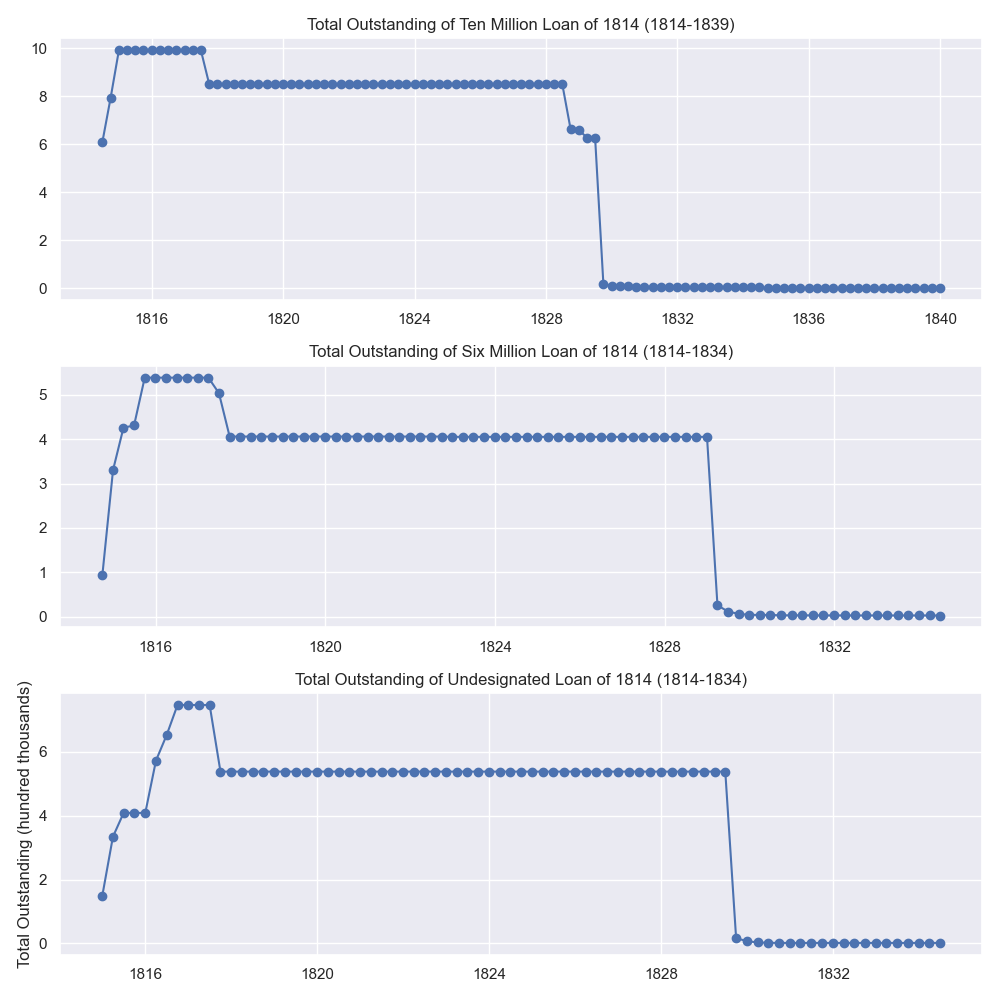

In [41]:
# ten million loan
ten_mil_quant = bond_quant[bond_quant["L1 ID"] == 20056]
ten_mil_quant = clean_quant(ten_mil_quant)
ten_mil_quant = reformat_quant(ten_mil_quant, "Total Outstanding")

# six million loan 
six_mil_1814_quant = bond_quant[bond_quant["L1 ID"] == 20057]
six_mil_1814_quant = clean_quant(six_mil_1814_quant)
six_mil_1814_quant = reformat_quant(six_mil_1814_quant, "Total Outstanding")

# undesignated loan 
undesignated_1814_quant = bond_quant[bond_quant["L1 ID"] == 20058]
undesignated_1814_quant = clean_quant(undesignated_1814_quant)
undesignated_1814_quant = reformat_quant(undesignated_1814_quant, "Total Outstanding")

# Create subplots of outstanding debt 
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

generate_quant_plot(ten_mil_quant, "Total Outstanding of Ten Million Loan of 1814 (1814-1839)", ax[0])
generate_quant_plot(six_mil_1814_quant, "Total Outstanding of Six Million Loan of 1814 (1814-1834)", ax[1])
generate_quant_plot(undesignated_1814_quant, "Total Outstanding of Undesignated Loan of 1814 (1814-1834)", ax[2])

fig.tight_layout()

In [27]:
# Group six percent loans quantities into one dataframe 
six_percent_loans_1814 = pd.concat([ten_mil_quant.copy(), six_mil_1814_quant.copy(), undesignated_1814_quant.copy()])
six_percent_loans_1814.reset_index(drop=True, inplace=True)
# Merge rows with the same timestamps, add Quants 
six_percent_loans_1814_quant = six_percent_loans_1814.groupby("Timestamp", as_index=False).aggregate({"Quant":"sum"}) 

### Visualizing Total Oustanding 

The stacked area plot will help compare total amount outstanding between different bonds. Instead of having every bond and note on one chart, we chose the following bonds and notes below and grouped the rest in an 'Other' category. By doing so, the graph remains readable and useful. 

1. Treasury Notes 1812-1814: There were four separate issues of treasury notes. We decided to group all four issues into one category because the notes in themselves were different from the long-term bonds issued by Congress. Notes were short-term bonds. Therefore, by grouping them together, it becomes easier to compare the quantity of short-term bonds against long-term bonds at any given point. 
2. Sixteen Million Loan of 1813: Based on the research, the Sixteen Million Loan was one of the most important long-term bonds issued by Congress during the war because, according to Perkins, it was the first time the government relied on outside financiers for "investment banking functions". The primary purchasers were not many individuals, but a syndicate consisting of Astor, Parish, and Girard.
3. Six Percent Loan of 1812: The first loan authorized by Congress in regards to the War of 1812. Therefore, it would be useful to compare total outstanding of the Six Percent stock compared to notes and loans that were issued later, to see if the amount oustanding for every note/bond increased or decreased as time went on. 

In [28]:
# group treasury notes into one dataframe 
# Combine all treasury notes into one dataframe 
treasury_notes_combined = pd.concat([treasury_notes_1812_quant.copy(), treasury_notes_1813_quant.copy(), treasury_notes_1814_quant.copy()])
treasury_notes_combined.reset_index(drop=True, inplace=True)
# Merge rows with the same timestamps, add Quants 
treasury_notes_combined = treasury_notes_combined.groupby("Timestamp", as_index=False).aggregate({"Quant":"sum"}) 

In [29]:
# Combine all other long-term loans into a separate dataframe 
other_loans = [
    six_percent_loans_1814_quant,
    seven_one_half_quant,
    exchanged_six_quant
]
others_combined = pd.concat(other_loans)
others_combined.reset_index(drop=True, inplace=True)

# Merge rows with the same timestamps, add Quants 
others_combined = others_combined.groupby("Timestamp").aggregate({"Quant":"sum"})

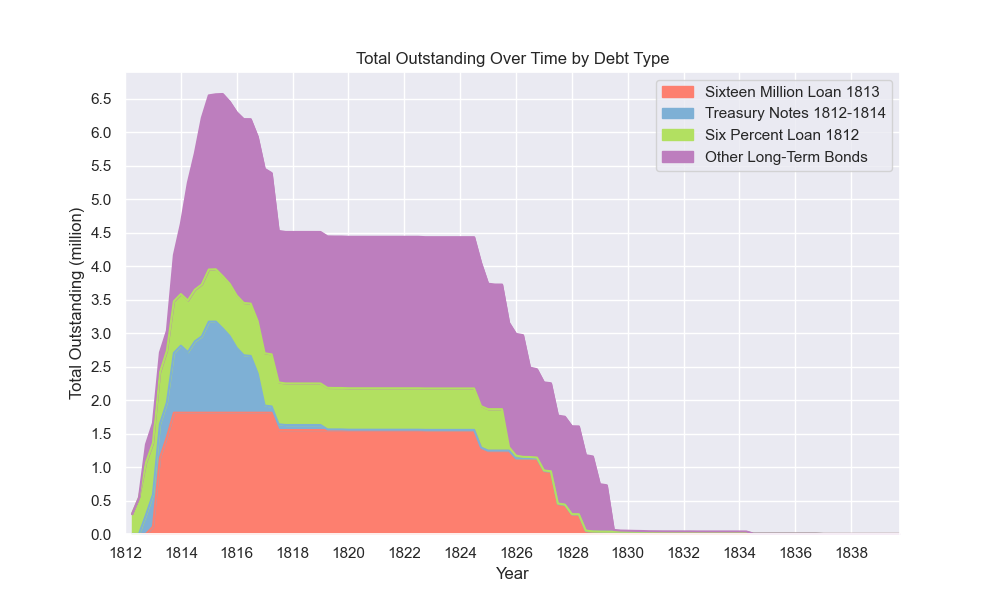

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Close all plots 
plt.clf()

# reformat dataframe for easier concatenation 
copy_sixteen_mil = sixteen_mil_quant
copy_sixteen_mil = copy_sixteen_mil.set_index("Timestamp") 

copy_treasure_notes = treasury_notes_combined
copy_treasure_notes = copy_treasure_notes.set_index("Timestamp") 

copy_six_percent_1812 = six_percent_1812_quant
copy_six_percent_1812 = copy_six_percent_1812.set_index("Timestamp") 

combined = pd.concat([copy_sixteen_mil, copy_treasure_notes, copy_six_percent_1812, others_combined.copy()], axis=1)
combined.columns.values[0] = "Sixteen Million Loan 1813"
combined.columns.values[1] = "Treasury Notes 1812-1814"
combined.columns.values[2] = "Six Percent Loan 1812"
combined.columns.values[3] = "Other Long-Term Bonds"
combined = combined.reset_index()

years = combined.index.tolist()
# Set the Seaborn style
sns.set(style="darkgrid")

# Plotting
f_plot = combined.plot(x="Timestamp", kind='area', stacked=True, figsize=(10, 6), legend=False, color=["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe"])

# set x axis tick marks manually
years = pd.date_range(start='1812', end='1839', freq='2YE').year
plt.xticks(pd.to_datetime(years, format='%Y'))
ax = plt.gca()
labels = ['1812', '1814', '1816', '1818', '1820', '1822', '1824', '1826', '1828', '1830', '1832', '1834', '1836', '1838'] 
ax.set_xticklabels(labels)

# set monthly locator
f_plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(x / 1e7))) # Removes '1e7' from axis 
f_plot.yaxis.set_ticks(np.arange(0, 7e7, 5e6)) 

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Outstanding (million)')
plt.title('Total Outstanding Over Time by Debt Type')
plt.legend(loc='upper right')

# Display the plot
plt.show()